## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center">Baseline Model</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#load)
* [4. Train a Baseline Model](#train)

# 1. Introduction <a class="anchor" id="intro"></a>
Bla Bla

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. 

In [1]:
import pandas as pd
import os
from glob import glob
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

2025-04-24 13:46:11.831632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745498771.847521   17501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745498771.852673   17501 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745498771.865598   17501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745498771.865615   17501 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745498771.865617   17501 computation_placer.cc:177] computation placer alr

# 3. Data Loading <a class="anchor" id="load"></a>

In [2]:
#Load and concatenate all train/test CSVs
train_csvs = glob('train_test_splits/*_train.csv')
test_csvs = glob('train_test_splits/*_test.csv')

# Load all CSVs into a list of DataFrames
train_dfs = [pd.read_csv(csv_path) for csv_path in train_csvs]
test_dfs = [pd.read_csv(csv_path) for csv_path in test_csvs]

# Concatenate them all
combined_train_df = pd.concat(train_dfs, ignore_index=True)
combined_test_df = pd.concat(test_dfs, ignore_index=True)

In [3]:
# Prepend image paths 
image_root_dir = "rare_species"
combined_train_df['filepath'] = combined_train_df['file_path'].apply(lambda x: os.path.join(image_root_dir, x))
combined_test_df['filepath'] = combined_test_df['file_path'].apply(lambda x: os.path.join(image_root_dir, x))

In [4]:
# Data generator for TRAINING images (includes augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Normalize pixel values from [0, 255] → [0, 1]
    rotation_range=15,         # Randomly rotate images by up to 15 degrees 
    zoom_range=0.1,            # Random zoom inside image (10%) 
    horizontal_flip=True,      # Randomly do mirror view
    validation_split=0.2       # Reserve 20% of training data for validation 
)

# Data generator for TEST images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Function to create generators based on image size and batch size
def create_generators(image_size=(128, 128), batch_size=16):
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=combined_train_df,         # DataFrame with image filepaths and labels
            x_col='filepath',                 # Column with full path to images
            y_col='family',                   # Column with class labels (family)
            target_size=image_size,           # Resize all images to this size
            class_mode='categorical',         # One-hot encode class labels
            batch_size=batch_size,            # Load this many images per batch
            subset='training',                # Use the training subset (80%)
            shuffle=True,                     # Shuffle the data for training
            seed=4                            # For reproducibility
    )

    val_generator = train_datagen.flow_from_dataframe(
            dataframe=combined_train_df,         # DataFrame with image filepaths and labels
            x_col='filepath',                 # Column with full path to images
            y_col='family',                   # Column with class labels (family)
            target_size=image_size,           # Resize all images to this size
            class_mode='categorical',         # One-hot encode class labels
            batch_size=batch_size,            # Load this many images per batch
            subset='validation',              # Use the training subset (80%)
            shuffle=True,                     # Shuffle the data for training
            seed=4                            # For reproducibility
    )

    test_generator = test_datagen.flow_from_dataframe(
            dataframe=combined_test_df,
            x_col='filepath',
            y_col='family',
            target_size=image_size,
            class_mode='categorical',
            batch_size=1,                     # Load one image at a time for testing
            shuffle=False                     # Do not shuffle so predictions align with input order
    )

    return train_generator, val_generator, test_generator

In [5]:
checkpoint = ModelCheckpoint(
    filepath='model_checkpoints/epoch_{epoch:02d}_valacc_{val_accuracy:.2f}.keras',
    save_weights_only=False,        # Set to True if you only want weights
    save_best_only=False,           # Or True if you only want best model
    monitor='val_accuracy',             # Metric to track
    mode='max',                    # Maximize this metric
    verbose=1
)

# 4. Train a Baseline Model <a class="anchor" id="train"></a>

In [6]:
# Create generators 
image_size = (224, 224)
batch_size = 32

train_generator, val_generator, test_generator = create_generators(
    image_size=image_size,
    batch_size=batch_size
)

Found 7566 validated image filenames belonging to 202 classes.
Found 1891 validated image filenames belonging to 202 classes.
Found 2367 validated image filenames belonging to 202 classes.


In [7]:
# Load VGG16 
base_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,       # Don't include the original classifier
    weights='imagenet'
)
base_model.trainable = False  # freeze all layers for baseline

# Build full model 
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),       # More efficient than Flatten
    layers.Dense(512, activation='relu'),  # Larger dense layer for higher class count
    layers.Dropout(0.5),
    layers.Dense(202, activation='softmax')  # Final output layer for 202 classes
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

I0000 00:00:1745498786.107450   17501 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:07:00.0, compute capability: 8.6


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [ ]:
# Train the model 
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"), checkpoint],
    verbose=1
)

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1745446258.328949   10909 service.cc:152] XLA service 0x7f4af0005cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745446258.328986   10909 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-23 23:10:58.356490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745446258.615987   10909 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-23 23:10:59.740661: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 188 bytes spill stores, 188 bytes spill loads

2025-04-23 23:10:59.856016: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1110

  2/237 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.0000e+00 - loss: 5.4528 

I0000 00:00:1745446266.358122   10909 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 93/237 ━━━━━━━━━━━━━━━━━━━━ 1:28 613ms/step - accuracy: 0.0071 - loss: 5.3511

2025-04-23 23:12:03.602305: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 8 bytes spill stores, 8 bytes spill loads

2025-04-23 23:12:03.632613: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 4 bytes spill stores, 4 bytes spill loads

2025-04-23 23:12:03.930436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 104 bytes spill stores, 104 bytes spill loads

2025-04-23 23:12:04.389469: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1110', 152 bytes spill stores, 152 bytes spill loads



237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.0153 - loss: 5.2652

2025-04-23 23:13:39.338968: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 120 bytes spill stores, 120 bytes spill loads

2025-04-23 23:13:39.472843: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 76 bytes spill stores, 76 bytes spill loads

2025-04-23 23:13:39.570276: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 636 bytes spill stores, 636 bytes spill loads

/root/DeepLearning2425/tf-gpu/lib/python3.12/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
2025-04-23 23:14:18.525915: I external/local_xla/xla/s


Epoch 1: saving model to model_checkpoints/epoch_01_valacc_0.02.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 205s 829ms/step - accuracy: 0.0154 - loss: 5.2647 - val_accuracy: 0.0164 - val_loss: 5.8355
Epoch 2/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.0405 - loss: 4.9694
Epoch 2: saving model to model_checkpoints/epoch_02_valacc_0.03.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 171s 722ms/step - accuracy: 0.0405 - loss: 4.9693 - val_accuracy: 0.0264 - val_loss: 6.1793
Epoch 3/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.0607 - loss: 4.8371
Epoch 3: saving model to model_checkpoints/epoch_03_valacc_0.04.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 172s 726ms/step - accuracy: 0.0607 - loss: 4.8371 - val_accuracy: 0.0354 - val_loss: 6.4063
Epoch 4/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.0744 - loss: 4.7540
Epoch 4: saving model to model_checkpoints/epoch_04_valacc_0.04.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 172s 724ms/step - accuracy: 0.0744 - loss: 4.7540 - val_accurac

In [8]:
model = load_model('model_checkpoints/epoch_22_valacc_0.08.keras')

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    initial_epoch=20,  # Replace with the epoch number you want to continue from
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"), checkpoint],
    verbose=1
)

Epoch 21/30


I0000 00:00:1745498869.172858   17667 service.cc:152] XLA service 0x7ffa24004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745498869.172894   17667 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-04-24 13:47:49.198665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745498869.495383   17667 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-24 13:47:50.671641: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 188 bytes spill stores, 188 bytes spill loads

2025-04-24 13:47:50.841860: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1110

  2/237 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.1641 - loss: 4.2334 

I0000 00:00:1745498878.486987   17667 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 42/237 ━━━━━━━━━━━━━━━━━━━━ 2:00 620ms/step - accuracy: 0.1806 - loss: 3.9580

2025-04-24 13:48:24.996114: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 8 bytes spill stores, 8 bytes spill loads

2025-04-24 13:48:25.283734: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 104 bytes spill stores, 104 bytes spill loads

2025-04-24 13:48:25.333848: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_921', 4 bytes spill stores, 4 bytes spill loads

2025-04-24 13:48:26.121573: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1110', 152 bytes spill stores, 152 bytes spill loads



237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.1745 - loss: 3.9206

/home/timst/DeepLearning2425/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-04-24 13:50:30.085809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 120 bytes spill stores, 120 bytes spill loads

2025-04-24 13:50:30.240866: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_234', 76 bytes spill stores, 76 bytes spill loads

2025-04-24 13:50:30.389571: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg


Epoch 21: saving model to model_checkpoints/epoch_21_valacc_0.08.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 207s 830ms/step - accuracy: 0.1744 - loss: 3.9206 - val_accuracy: 0.0836 - val_loss: 8.6867
Epoch 22/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.1803 - loss: 3.8627
Epoch 22: saving model to model_checkpoints/epoch_22_valacc_0.08.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 175s 737ms/step - accuracy: 0.1803 - loss: 3.8628 - val_accuracy: 0.0846 - val_loss: 8.6969
Epoch 23/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.1755 - loss: 3.8758
Epoch 23: saving model to model_checkpoints/epoch_23_valacc_0.09.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 176s 743ms/step - accuracy: 0.1756 - loss: 3.8758 - val_accuracy: 0.0915 - val_loss: 8.8475
Epoch 24/30
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.1751 - loss: 3.8441
Epoch 24: saving model to model_checkpoints/epoch_24_valacc_0.09.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 172s 728ms/step - accuracy: 0.1751 - loss: 3.8441 - val_

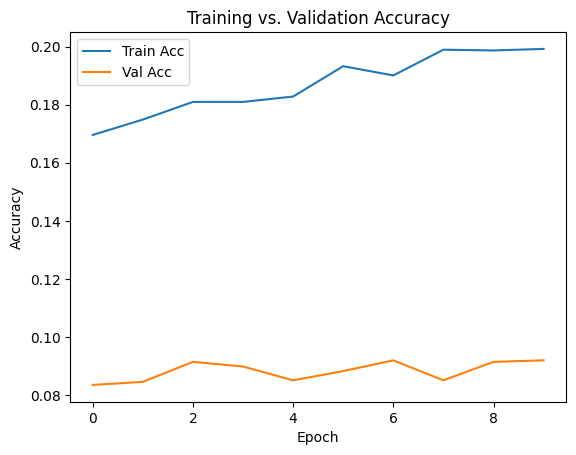

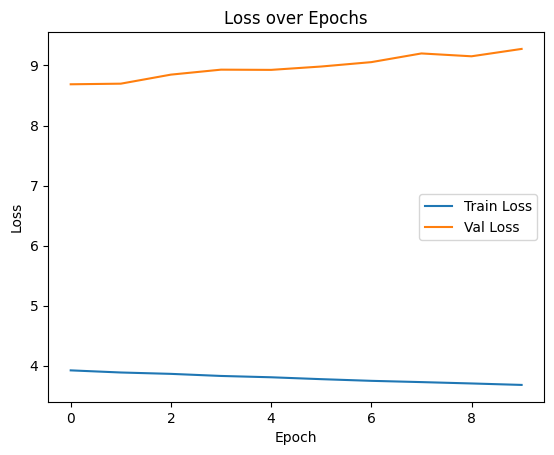

In [13]:
import matplotlib.pyplot as plt

# plot the accuracy results
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Plot the loss results
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()